In [1]:
from torchvision.transforms import Resize
from utils import *
from models.closedform.utils import load_generator
from torchvision.utils import save_image
import numpy as np
import random
import torch.nn.functional as F
from torchvision.models import resnet18
import torch.nn as nn
import matplotlib.pylab as plt
import torchvision
import cv2
from IPython import display
%matplotlib inline

In [2]:
def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        np.random.seed(seed)
        random.seed(seed)
        os.environ['PYTHONHASHSEED'] = str(seed)

## Configurations

In [3]:
random_seed = 1234
set_seed(random_seed)
# load_codes = True
algo = 'ortho'
root_dir= '/home/adarsh/PycharmProjects/disentagled_latent_dirs'
result_path = os.path.join(root_dir,  'results/anime/closed_form_ours/qualitative_analysis')

## Model Selection

In [4]:
deformator_path = os.path.join(root_dir, 'pretrained_models/deformators/ClosedForm/stylegan_animeface512/stylegan_animeface512.pkl')
layers, cf_deformator, _ = torch.load(deformator_path, map_location='cpu')
cf_deformator = torch.FloatTensor(cf_deformator).cuda()

deformator_path = os.path.join(root_dir, 'results/anime/closedform_ours/models/20000_model.pkl')
algo == 'ortho'
if algo == 'ortho':
    deformator = torch.load(deformator_path)['deformator']['ortho_mat']
    dse_deformator = deformator.T
elif algo == 'linear':
    deformator = torch.load(os.path.join(deformator_path))['deformator']
    dse_deformator = deformator.T
        
generator = load_generator(None, model_name='stylegan_animeface512')

# if load_codes:

# else:
num_samples = 10
codes = torch.randn(num_samples, 512).cuda()
w = generator.mapping(codes)['w']
codes  = generator.truncation(w, trunc_psi = 0.7, trunc_layers = 8)

Building generator for model `stylegan_animeface512` ...
Finish building generator.
Loading checkpoint from `../pretrained_models/generators/ClosedForm/stylegan_animeface512.pth` ...
Finish loading checkpoint.


In [5]:
codes.shape

torch.Size([10, 16, 512])

Figure : 0


<Figure size 2160x2160 with 0 Axes>

Figure : 1


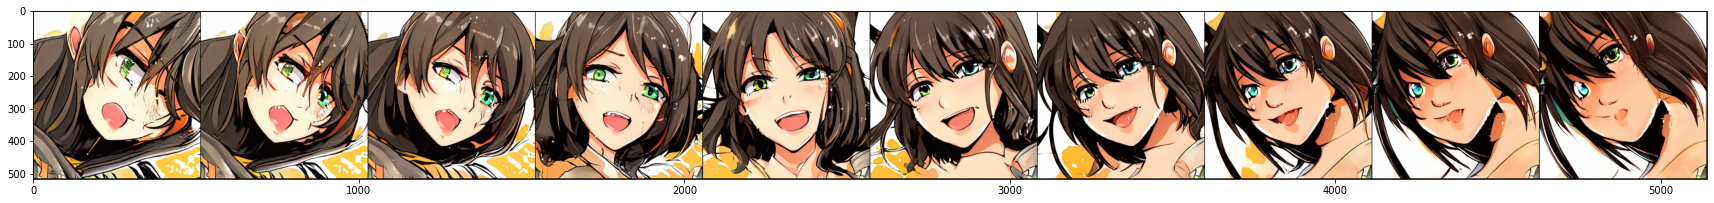

Figure : 2


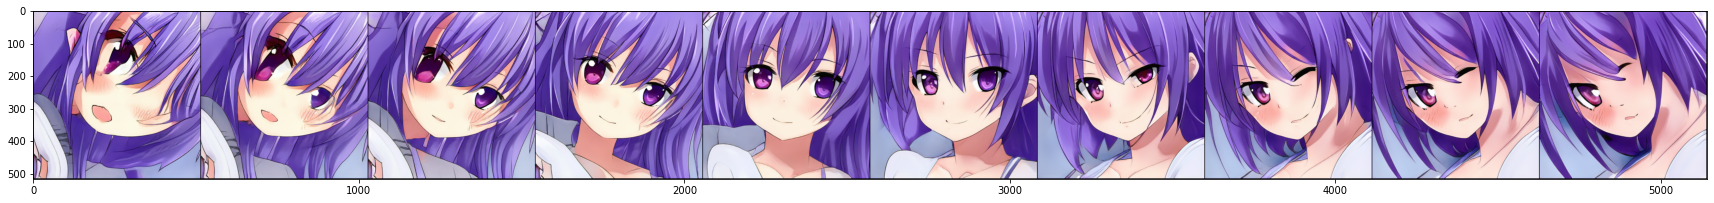

Figure : 3


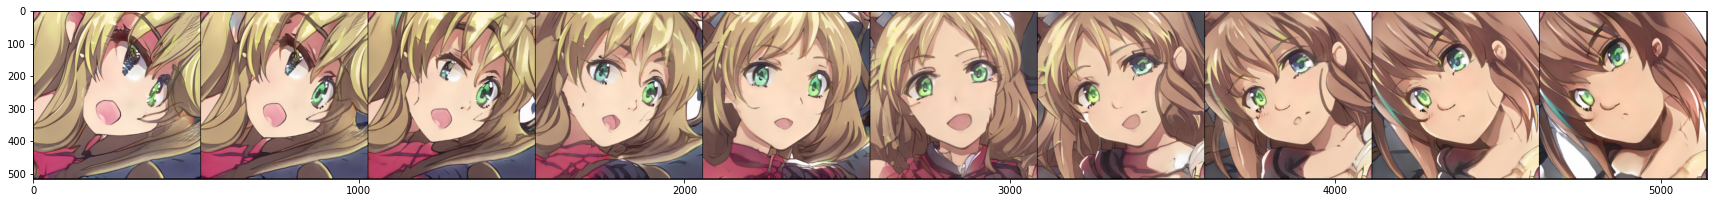

Figure : 4


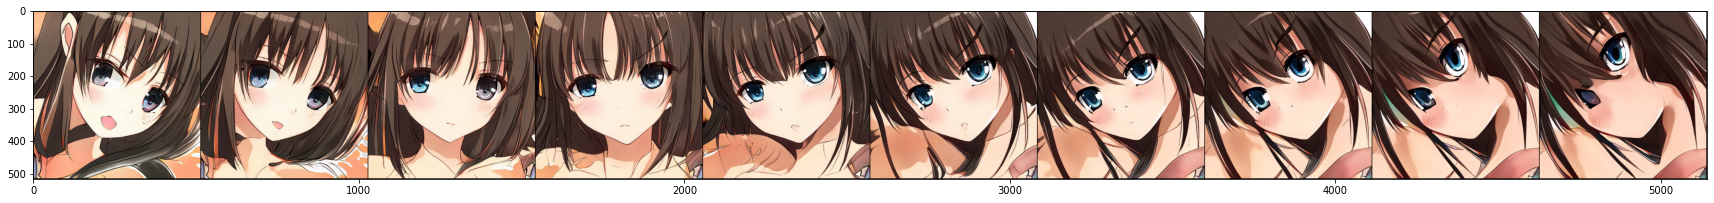

Figure : 5


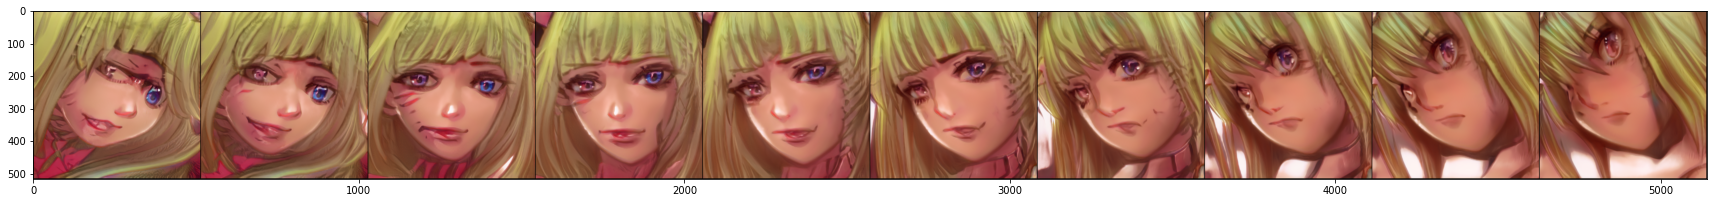

Figure : 6


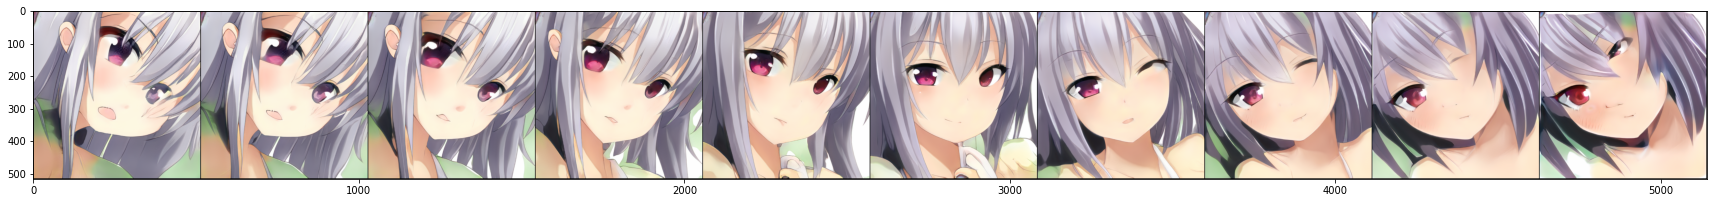

Figure : 7


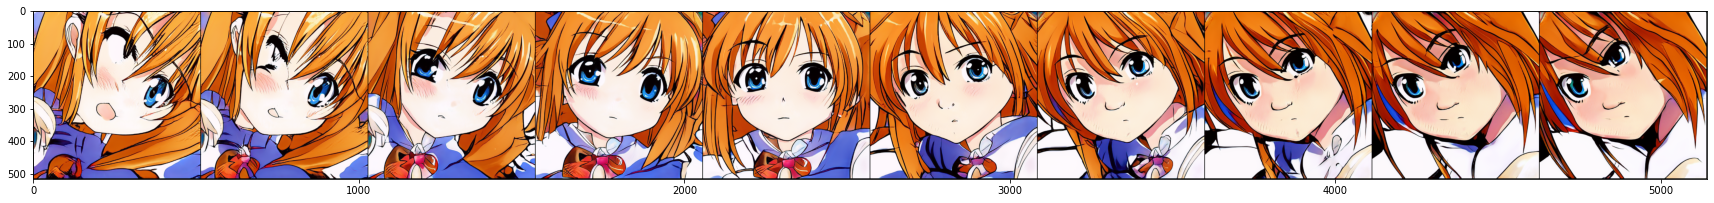

Figure : 8


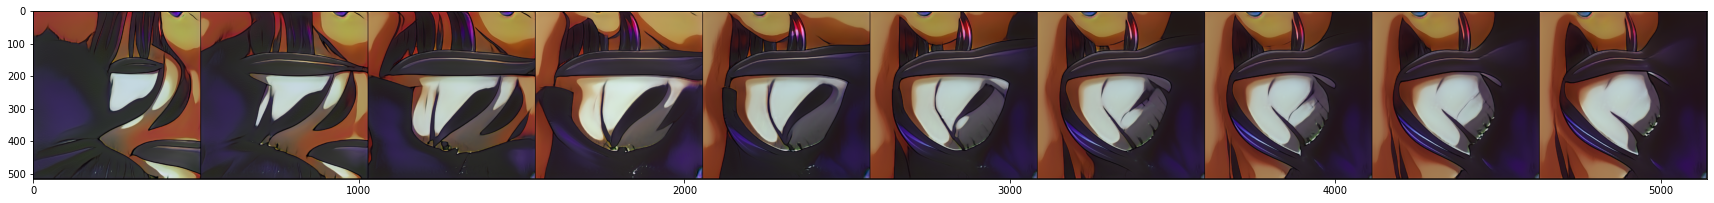

Figure : 9


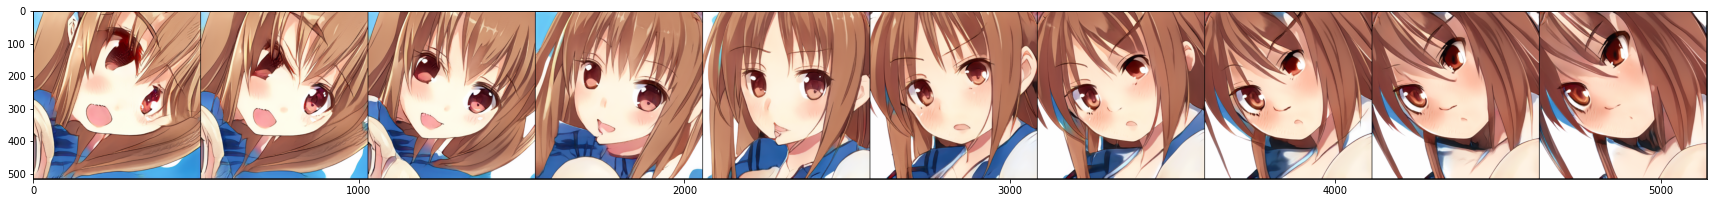

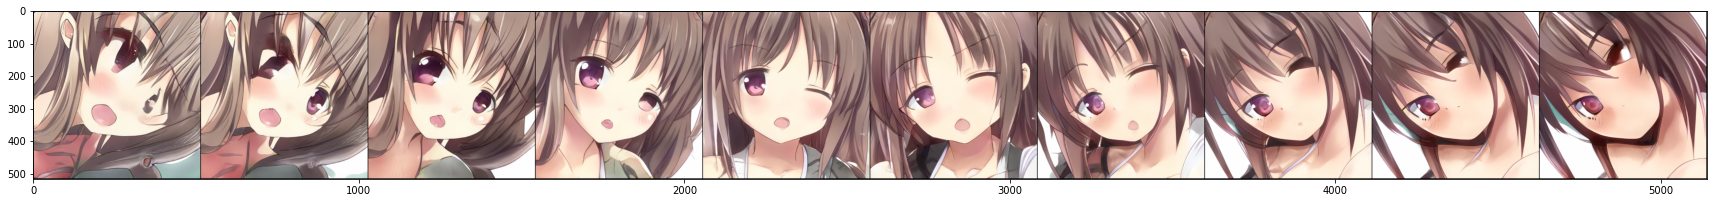

In [6]:
def postprocess_images(images):
        """Post-processes images from `torch.Tensor` to `numpy.ndarray`."""
        images = images.detach().cpu().numpy()
        images = (images + 1) * 255 / 2
        images = np.clip(images + 0.5, 0, 255).astype(np.uint8)
        images = images.transpose(0, 2, 3, 1)
        return images


def save_images(codes, shifts_r, shifts_count, dir_, generator, deformator):
        temp_path = os.path.join(result_path, 'temp')
        os.makedirs(temp_path , exist_ok=True)
        plt.figure(figsize=(30,30))
        for idx, z in enumerate(codes):
            print('Figure : ' + str(idx))
            z_shift = []
            for i, shift in enumerate(np.linspace(-shifts_r,shifts_r,shifts_count)):
                shift_epsilon = (deformator[dir_: dir_ + 1] * shift).unsqueeze(1).repeat(1,len(layers),1)
                z_shift.append(z + shift_epsilon)
            z_shift = torch.stack(z_shift).squeeze(dim=1)
            with torch.no_grad():
                images= generator.synthesis(z_shift)
            torch.save(images, os.path.join(temp_path, 'cf.pkl'))
            del images

            images = torch.load(os.path.join(temp_path, 'cf.pkl'))
            grid = torchvision.utils.make_grid(images.clamp(min=-1, max=1),nrow=10, scale_each=True, normalize=True)
            display.display(plt.gcf())
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            del images
            del grid

    
z_min_index = 0
z_max_index = 10
codes = codes[z_min_index:z_max_index]
dir_ = 3
shift_r = 3
shift_count = 10
all_images = save_images(codes, shift_r, shift_count, dir_,  generator, cf_deformator)                    

In [ ]:
def postprocess_images(images):
        """Post-processes images from `torch.Tensor` to `numpy.ndarray`."""
        images = images.detach().cpu().numpy()
        images = (images + 1) * 255 / 2
        images = np.clip(images + 0.5, 0, 255).astype(np.uint8)
        images = images.transpose(0, 2, 3, 1)
        return images


def save_images(codes, shifts_r, shifts_count, cf_dir, dse_dir, generator, cf_deformator, dse_deformator):
        plt.figure(figsize=(30,30))
        for idx, z in enumerate(codes):
            print('Figure : ' + str(idx))
            z_shift_cf = []
            z_shift_dse = []
            for i, shift in enumerate(np.linspace(-shifts_r,shifts_r,shifts_count)):
                z_shift_cf.append(z + cf_deformator[cf_dir: cf_dir + 1] * shift)
                z_shift_dse.append(z + dse_deformator[dse_dir: dse_dir + 1] * shift)
            z_shift_cf = torch.stack(z_shift_cf).squeeze(dim=1)
            z_shift_dse = torch.stack(z_shift_dse).squeeze(dim=1)
            with torch.no_grad():
                cf_images= generator(z_shift_cf)
            torch.save(cf_images, os.path.join(result_path, 'temp', 'cf.pkl'))
            del cf_images
            with torch.no_grad():
                dse_images= generator(z_shift_dse)
            torch.save(dse_images, os.path.join(result_path, 'temp', 'dse.pkl'))
            del dse_images
            cf_images = torch.load(os.path.join(result_path, 'temp', 'cf.pkl'))
            dse_images = torch.load(os.path.join(result_path, 'temp', 'dse.pkl'))
            all_images = torch.cat((cf_images, dse_images), dim=0)
            grid = torchvision.utils.make_grid(all_images.clamp(min=-1, max=1),nrow=10, scale_each=True, normalize=True)
            display.display(plt.gcf())
            plt.imshow(grid.permute(1, 2, 0).cpu().numpy())
            del all_images
            del cf_images
            del dse_images
            del grid

    
z_min_index = 0
z_max_index = 5
cf_dir = 1
dse_dir = 1
shift_r = 10
shift_count = 10
all_images = save_images(codes[z_min_index:z_max_index], shift_r, shift_count, cf_dir, dse_dir, generator, cf_deformator, dse_deformator)                    